In [ ]:
# NOTE: You need to have 'numpy' and 'matplotlib' installed to run this code.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [ ]:
# Load DEM and catchment boundary data
# NOTE: Your might need to adjust the file paths below
X = np.loadtxt("../Addis2025_DEM/X_Abaya_DEM.txt")
Y = np.loadtxt("../Addis2025_DEM/Y_Abaya_DEM.txt")
Z = np.loadtxt("../Addis2025_DEM/Abaya_DEM.txt")
xb = np.loadtxt("../Addis2025_DEM/X_Abaya_catchment_boundary_try.txt")
yb = np.loadtxt("../Addis2025_DEM/Y_Abaya_catchment_boundary_try.txt")

In [3]:
def compute_slopes_in_percentage(X, Y, Z):
    # Compute grid spacing
    dx = np.mean(np.diff(X, axis=1))
    dy = np.mean(np.diff(Y, axis=0))

    # Cardinal direction slopes
    dZdy, dZdx = np.gradient(Z, dy, dx)

    # Diagonal spacing
    diag_dist = np.sqrt(dx**2 + dy**2)

    # Diagonal derivatives
    dZd_NE = np.zeros_like(Z)
    dZd_NW = np.zeros_like(Z)

    dZd_NE[1:-1, 1:-1] = (Z[2:, 2:] - Z[:-2, :-2]) / (2 * diag_dist)
    dZd_NW[1:-1, 1:-1] = (Z[2:, :-2] - Z[:-2, 2:]) / (2 * diag_dist)

    # Convert slope (rise/run) to 0–1 percentage
    def slope_to_percentage(s):
        return np.abs(s) / (1 + np.abs(s))

    # Convert each direction
    sx = slope_to_percentage(dZdx)
    sy = slope_to_percentage(dZdy)
    sNE = slope_to_percentage(dZd_NE)
    sNW = slope_to_percentage(dZd_NW)

    # Take maximum slope per cell
    slope = np.maximum.reduce([sx, sy, sNE, sNW])

    return slope


def create_water_mask(slope):
    water_mask_1 = slope == 0.0
    water_mask_2 = Y < 0.75e6
    water_mask = water_mask_1 * water_mask_2
    return water_mask


def create_catchment_area_mask(X, Y, xb, yb):
    # Create mask
    boundary_polygon = Path(np.column_stack([xb, yb]))
    points = np.column_stack([X.ravel(), Y.ravel()])
    mask_flat = boundary_polygon.contains_points(points)
    mask = mask_flat.reshape(X.shape)
    return mask


slope = compute_slopes_in_percentage(X, Y, Z)
water_mask = create_water_mask(slope)
cachment_area_mask = create_catchment_area_mask(X, Y, xb, yb)

# Get the domain of the
X_catchment, Y_catchment = np.where(cachment_area_mask == True)
X_catchment_min = X[X_catchment, Y_catchment].min()
X_catchment_max = X[X_catchment, Y_catchment].max()
Y_catchment_min = Y[X_catchment, Y_catchment].min()
Y_catchment_max = Y[X_catchment, Y_catchment].max()
catchment_domain = (X_catchment_min, X_catchment_max, Y_catchment_min, Y_catchment_max)


In [4]:
def plot_field(
    X,
    Y,
    vals,
    title: str = "",
    save_fig: bool = True,
    xb=None,
    yb=None,
    cmap="viridis",
    catchment_domain=None,
    cachment_area_mask=None,
    water_mask=None,
    remove_colorbar=False
):
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Set values outside catchment to NaN for better plotting
    if cachment_area_mask is not None:
        vals[~cachment_area_mask] = np.nan
    if water_mask is not None:
        vals[water_mask] = np.nan

    # DEM plot
    im0 = ax.imshow(
        vals, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap
    )

    if xb is not None and yb is not None:
        ax.plot(xb, yb, "k-", linewidth=2)

    if catchment_domain is not None:
        padding = 1e4
        x_c_min, x_c_max, y_c_min, y_c_max = catchment_domain
        ax.set_xlim(x_c_min - padding, x_c_max + padding)
        ax.set_ylim(y_c_min - padding, y_c_max + padding)

    ax.set_title(title)
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    if not remove_colorbar:
        fig.colorbar(im0, ax=ax)
    if save_fig:
        plt.savefig(f"Figures/{title}.pdf")
    plt.show()

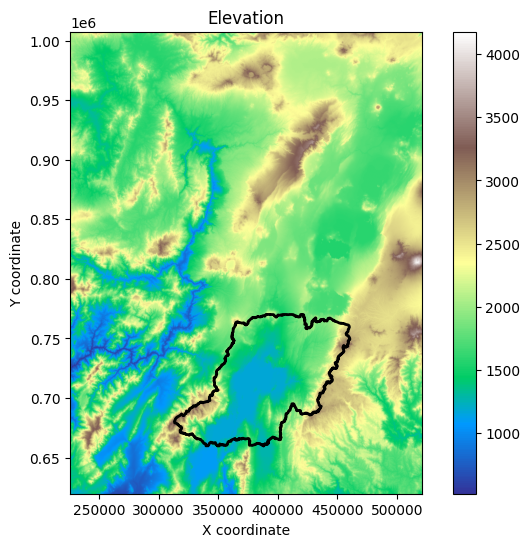

In [5]:
plot_field(X, Y, Z.copy(), "Elevation", xb=xb, yb=yb, cmap="terrain")

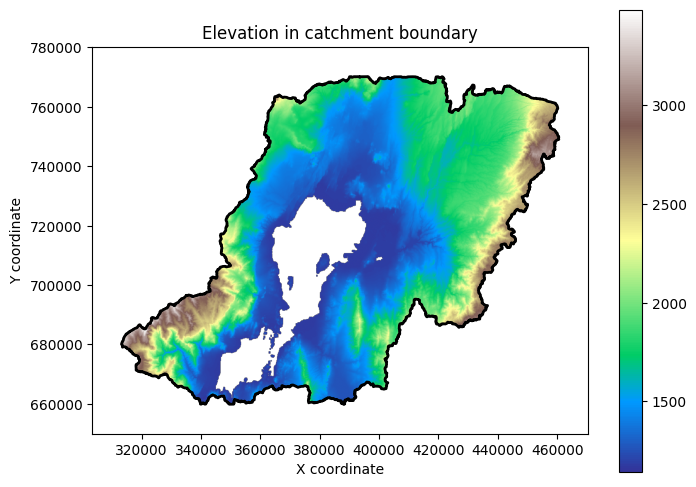

In [6]:
plot_field(
    X,
    Y,
    Z.copy(),
    "Elevation in catchment boundary",
    xb=xb,
    yb=yb,
    cmap="terrain",
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

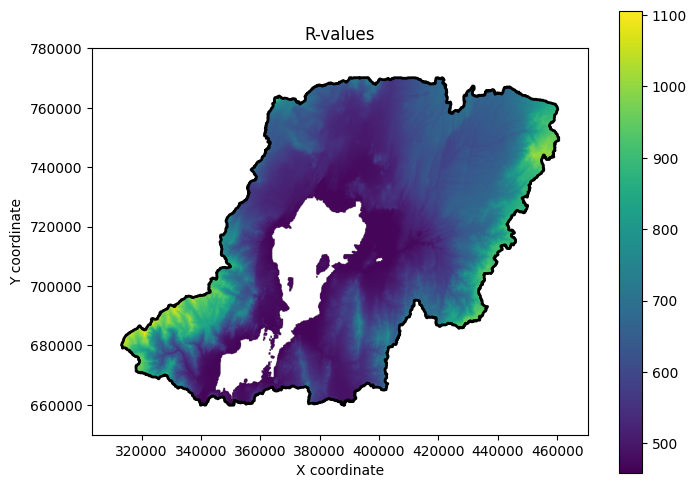

In [7]:
precip_mat = 266.21 + 0.493 * Z
R = -8.12 + 0.562 * precip_mat
plot_field(
    X,
    Y,
    R.copy(),
    "R-values",
    xb=xb,
    yb=yb,
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

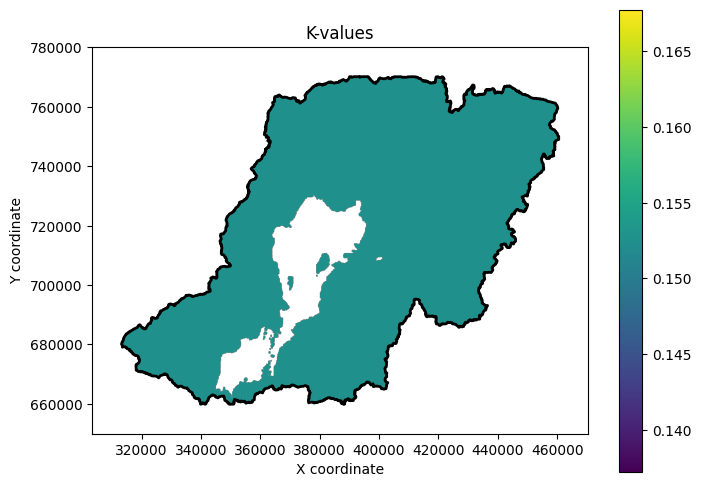

In [9]:
K = np.ones_like(Z) * 0.1525
K[water_mask] = 0.0
plot_field(
    X,
    Y,
    K.copy(),
    "K-values",
    xb=xb,
    yb=yb,
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

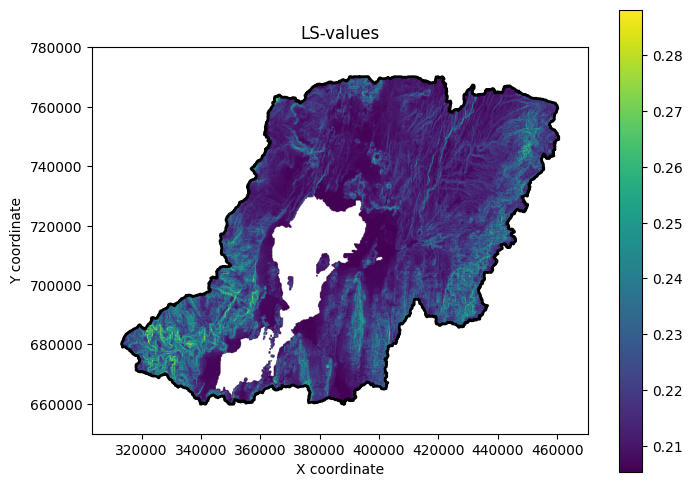

In [10]:
dx = np.mean(np.diff(X, axis=1))
dy = np.mean(np.diff(Y, axis=0))
slope_length = np.sqrt(dx**2 + dy**2)
LS = (0.065 + 0.0456 * slope + 0.006541 * (slope**2)) * (slope_length / 22.1) ** 0.5
plot_field(
    X,
    Y,
    LS.copy(),
    "LS-values",
    xb=xb,
    yb=yb,
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

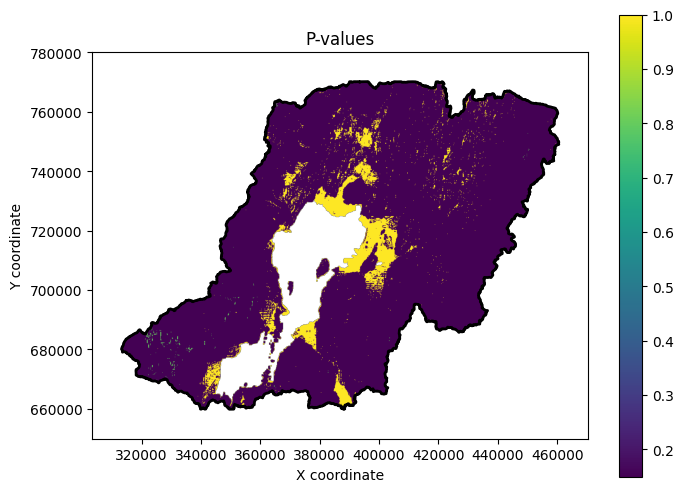

In [ ]:
def create_P(Z, slope):
    P = np.ones_like(Z)

    binned_values = [
        0.15,  # Crops
        0.15,  # Crops
        0.8,  # Bare land
    ]

    # ---- Binning into 10 bins ----
    num_bins = 3
    bins = np.linspace(slope.min() + 0.01, slope.max(), num_bins + 1)
    binned_slopes = np.digitize(slope, bins) - 1  # subtract 1 so bins go 0..9

    for i in range(len(binned_values)):
        P[binned_slopes == i] = binned_values[i]

    P[water_mask] = 0.0
    return P


P = create_P(Z, slope)

plot_field(
    X,
    Y,
    P.copy(),
    "P-values",
    xb=xb,
    yb=yb,
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

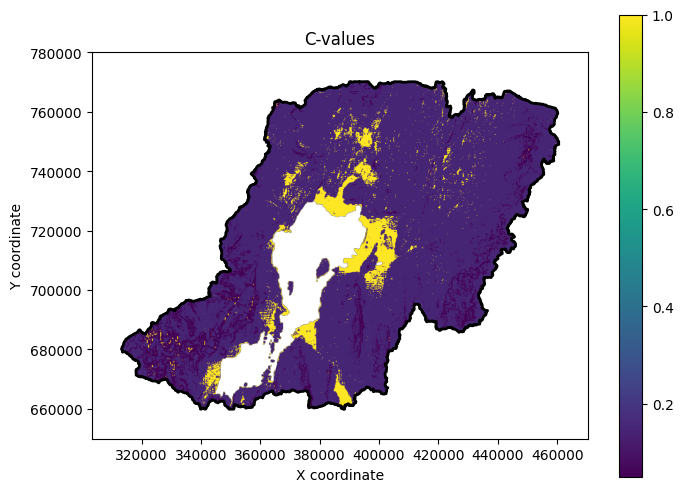

In [ ]:
def create_C(Z, slope, with_reforestation=False):
    C = np.ones_like(Z)

    binned_values = [
        0.05 if with_reforestation else 0.15,  # Crops
        0.05,  # Trees
        1,  # Bare land
    ]

    # ---- Binning into 10 bins ----
    num_bins = 3
    bins = np.linspace(slope.min() + 0.01, slope.max(), num_bins + 1)
    binned_slopes = np.digitize(slope, bins) - 1  # subtract 1 so bins go 0..9

    for i in range(len(binned_values)):
        C[binned_slopes == i] = binned_values[i]

    C[water_mask] = 0.0
    return C


C_without_reforestation = create_C(Z, slope, with_reforestation=False)
C_with_reforestation = create_C(Z, slope, with_reforestation=True) 
plot_field(
    X,
    Y,
    C_without_reforestation.copy(),
    "C-values without reforestation",
    xb=xb,
    yb=yb,
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

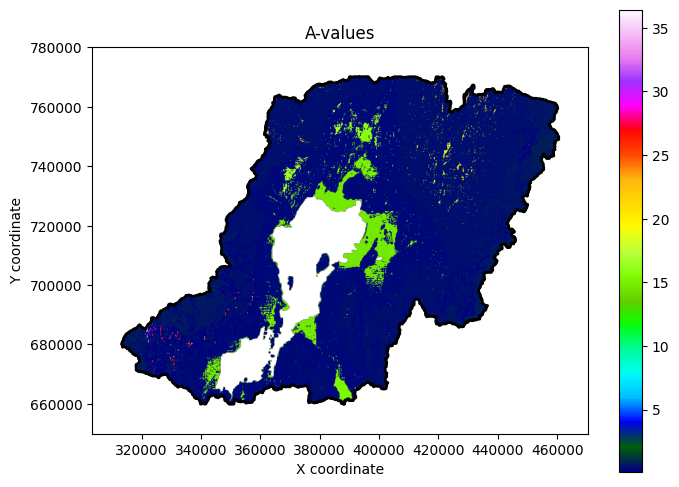

In [ ]:
A_without_reforestation = R * K * LS * C_without_reforestation * P
A_with_reforestation = R * K * LS * C_with_reforestation * P
plot_field(
    X,
    Y,
    A_without_reforestation.copy(),
    "A-values without reforestation",
    xb=xb,
    yb=yb,
    cmap="gist_ncar",
    # cmap="Paired",
    # cmap="Accent",
    catchment_domain=catchment_domain,
    cachment_area_mask=cachment_area_mask,
    water_mask=water_mask,
)

In [ ]:
area = 1140e6
depth = 8.61
volume_rough_estimate = area * depth
volume = 13456716598
cachment_area = np.sum(np.ones_like(Z) * cachment_area_mask * water_mask * dx * dy)
print(f"Cachment area: {cachment_area}")
print(f"Estimated volume: {volume}")

Volume: 9815400000.0
Volume improved estimate: 13456716598


In [ ]:
A_without_reforestation_masked = A_without_reforestation * cachment_area_mask
A_with_reforestation_masked = A_with_reforestation * cachment_area_mask

Cachment area: 1023560394.7766052


In [ ]:
erosion_vol_without_reforestation = np.sum(A_without_reforestation_masked * 1e-4 * dx * dy) / (2.65 * 0.4)
time_until_filled_without_reforestation = volume / erosion_vol_without_reforestation
print(f"Estimated time until the lake is filled without reforestation: {time_until_filled_without_reforestation:.2f} years")

erosion_vol_with_reforestation = np.sum(A_with_reforestation_masked * 1e-4 * dx * dy) / (2.65 * 0.4)
time_until_filled_with_reforestation = volume / erosion_vol_with_reforestation
print(f"Estimated time until the lake is filled with reforestation: {time_until_filled_with_reforestation:.2f} years")

Estimated time until the lake is filled: 10541.52 years
